In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, SCORERS
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns

In [8]:
X = pd.read_csv("Admission_Predict_Ver1.1.csv", index_col = "Serial No.")
Y = X.iloc[:,-1] # O lo que es igual X["Chance of Admit"]
X.drop(columns="Chance of Admit ", inplace=True)
X.describe()
#GRE = Puntaje de examen de admisión
#SOP = Statement of Purpose strength
#LOP = Letter of Recommendation strength
#CGPA = Calificación de GPA (Básicamente calificación de prepa)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000


In [3]:
Y.describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit , dtype: float64

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 7 columns):
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
dtypes: float64(3), int64(4)
memory usage: 31.2 KB


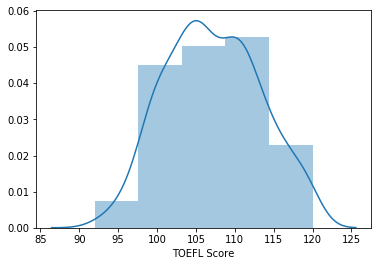

In [5]:
sns.distplot(X["TOEFL Score"], bins=5, kde=True)

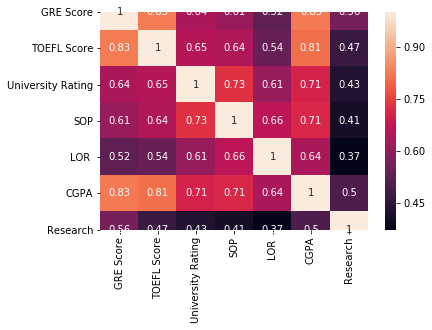

In [6]:
sns.heatmap(X.corr(),annot=True)

In [7]:
X["EntryDocs"] = X["SOP"] + X["LOR "]
X.drop(columns=["SOP", "LOR "], inplace=True)

In [58]:
X["SkillScores"] = (X["GRE Score"] + X["TOEFL Score"] + X["CGPA"])
X.drop(columns=["GRE Score", "TOEFL Score", "CGPA"], inplace=True)

In [62]:
X["SkillScores"] = (X["GRE Score"] + X["CGPA"])
X.drop(columns=["GRE Score", "TOEFL Score", "CGPA"], inplace=True)

In [9]:
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = mean_absolute_error(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = mean_absolute_error(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)
            
def mean_percentage_error(true_y, pred_y):
    error = (true_y - pred_y / true_y).mean() * 100
    return error

def mean_absolute_percentage_error(true_y, pred_y):
    error = (abs(true_y - pred_y) / true_y).mean() *100
    return error

In [10]:
def run_model(model, X, Y, bias=0):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.30)
    model.fit(X_train, Y_train)
    preds = model.predict(X_val) + bias
    print("MAE: " + str(mean_absolute_error(Y_val, preds)))
    print("MSE: " + str(mean_squared_error(Y_val, preds)))
    print("MAPE: " + str(mean_absolute_percentage_error(Y_val, preds)))
    print("MPE: " + str(mean_percentage_error(Y_val, preds)))
    print(permutation_importance(model, X_val, Y_val))
    

In [13]:
xgb = XGBRegressor(max_depth = 2, n_estimators=15, random_state = 0)
run_model(xgb, X, Y)
-1 * cross_val_score(xgb, X, Y, cv = 10, scoring='neg_mean_absolute_error').mean()

MAE: 0.04629395012060801
MSE: 0.004476439196850739
MAPE: 7.367589200067215
MPE: -30.028273369432114
                   Importancia  Desviacion estándar
CGPA                  0.054397             0.005211
GRE Score             0.014843             0.002703
Research              0.002148             0.000804
TOEFL Score           0.001656             0.001066
EntryDocs             0.001394             0.000476
University Rating     0.000350             0.000378


0.045950431432723995

In [52]:
parameters = { 
    "min_samples_split": [1.0, 5, 10],
    "max_depth" : [50, 100],
    "n_estimators" : [50,100,500]
             }
rfGrid = GridSearchCV(RandomForestRegressor(), parameters, cv= 10, scoring="neg_mean_absolute_error")
rfGrid.fit(X, Y)
print("Best parameters:")
print(rfGrid.best_params_)
print("Best score:")
print(-rfGrid.best_score_)

Best parameters:
{'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 50}
Best score:
0.0453938674348027


In [65]:
parameters = { 
    "max_depth" : [1, 2, 5, 10, 50, 100],
    "n_estimators" : [15, 10, 20, 25,50,100]
             }
xgbGrid = GridSearchCV(XGBRegressor(), parameters, cv= 10, scoring="neg_mean_absolute_error")
xgbGrid.fit(X, Y)
print("Best parameters:")
print(xgbGrid.best_params_)
print("Best score:")
print(-xgbGrid.best_score_)

Best parameters:
{'max_depth': 2, 'n_estimators': 25}
Best score:
0.05476876314401627


In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state = 100)
modelPI = XGBRegressor(max_depth=2, n_estimators=15)

permutation_importance(modelPI.fit(X_train, Y_train),  X_val, Y_val, 100)

,Importancia,Desviacion estándar
CGPA,0.064665,0.006305
GRE Score,0.011807,0.001815
Research,0.002996,0.001086
LOR,0.002960,0.001300
TOEFL Score,0.002117,0.000815
University Rating,0.002033,0.000655
SOP,0.000000,0.000000


In [49]:
rf = RandomForestRegressor(max_depth=100, min_samples_split=5, n_estimators=100)
run_model(rf, X, Y)

MAE: 0.0419729238844489
MSE: 0.00355988611633184
MAPE: 6.685354133384901
MAE: -29.867968320259266


In [73]:
rf.fit(X_train, Y_train)
PI = PermutationImportance(rf, scoring='neg_mean_absolute_error').fit(X_val, Y_val)
eli5.show_weights(PI, feature_names = X_train.columns.tolist())

Weight,Feature
0.0707 ± 0.0183,CGPA
0.0088 ± 0.0026,GRE Score
0.0022 ± 0.0014,Research
0.0022 ± 0.0024,EntryDocs
0.0020 ± 0.0010,University Rating
0.0004 ± 0.0018,TOEFL Score


In [74]:
permutation_importance(rf, X_val, Y_val, 5)

,Importancia,Desviacion estándar
CGPA,0.063400,0.006622
GRE Score,0.010535,0.002360
University Rating,0.002570,0.000530
Research,0.001420,0.000731
EntryDocs,0.001373,0.000448
TOEFL Score,0.000311,0.001162


In [53]:
list(SCORERS.keys())

['explained_variance',
 'r2',
 'max_error',
 'neg_median_absolute_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'accuracy',
 'roc_auc',
 'balanced_accuracy',
 'average_precision',
 'neg_log_loss',
 'brier_score_loss',
 'adjusted_rand_score',
 'homogeneity_score',
 'completeness_score',
 'v_measure_score',
 'mutual_info_score',
 'adjusted_mutual_info_score',
 'normalized_mutual_info_score',
 'fowlkes_mallows_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted']

In [136]:
test = np.full((5, 5), 0, dtype=float)
test[0] = np.arange(1,6)
test = pd.DataFrame(np.transpose(test))
#np.random.shuffle(test[0].values)
test

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0


In [137]:
new_X = pd.DataFrame(test, copy = True)
np.random.shuffle(new_X[0].values)
test

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0


In [139]:
X.columns[5]

'CGPA'